<a href="https://colab.research.google.com/github/jesusvc5/RL_LAVC/blob/main/SARSA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Implementación, análisis y evaluación del método de SARSA sobre el entorno Frozen Lake

*Description*: En este notebook se desarrolla la implementación del método de **SARSA** (State-Action-Reward-State-ACtion), y se emplea sobre el entorno Frozen Lake de Gymnasium.


    Autores: Jesús Verdú Chacón
             Jorge López Abad

    Emails: jesus.v.c@um.es
            jorge.lopeza@um.es
            
    Date: 2025/03/09


In [53]:
%%capture
!pip install 'gym[box2d]==0.20.0'

Establecemos la semilla para `Numpy`, para poder así conseguir reproducibilidad de los experimentos realizados.

In [54]:
# Intentamos fijar las semillas
import os
import torch
import gc
import numpy as np

# Configuración del dispositivo (CPU o GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Usando dispositivo: {device}")

# Liberación de memoria para evitar problemas de consumo en GPU
gc.collect() # Ejecuta el recolector de basura de Python
torch.cuda.empty_cache() # Vacía la caché de memoria en GPU

SEED = 42

# Fijar la semilla en NumPy
np.random.seed(SEED) # Para generar números aleatorios consistentes en NumPy
np.random.default_rng(SEED) # Establece una instancia del generador de NumPy con la misma semilla

# Fijar la semilla en Python
os.environ['PYTHONHASHSEED'] = str(SEED) # Evita variabilidad en hashing de Python

Usando dispositivo: cpu


In [55]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import gymnasium as gym


## Definición del agente

Hasta ahora hemos visto los métodos de Monte Carlo (On-Policy y Off-Policy), los cuales actualizaban sus valores $Q$ al final de cada episodio, lo cual podia llegar a ser limitante si el entorno llegaba a ser muy grande (como en el caso 8x8).

Introducimos ahora los métodos basados en aprendizaje por **Diferencias Temporales**. Son una combinación de las ideas de Monte Carlo (exploración del entorno para actualización de políticaprenden de la experiencia en bruto, y no de un modelo con las dinámicas del entorno) y Porgramación Dinámica (hacen bootstrap, en el sentido de que se actualizan los valores paso apaso, con estimaciones, y no al final del episodio como en Monte Carlo). Se sigue usando la **Iteración de Política Generalizada**, pero no se necesita el episodio entero para evaluar la política para un estado.

El primer método que implementamos de Diferencias Temporales es **SARSA**. Se trata de un método On-Policy, donde debemos estimar $q_\pi(s, a)$ para la política de comportamiento actual $\pi$. La **fórmula de actualización de SARSA** es:

$$
Q(S_t, A_t) ← Q(S_t, A_t) + \alpha(R_{t+1} + \gamma Q(S_{t+1}, A_{t+1}) - Q(S_t, A_t))
$$

Esa actualización se realiza después de cada transición desde un estado $S_t$ que no sea terminal.

La política de comportamiento, que a su vez, es la que intentamos optimizar (on-policy) es una $\epsilon$-greedy.

In [56]:
# actions
LEFT, DOWN, RIGHT, UP = 0,1,2,3

class AgentSARSA:
  def __init__(self,
               env:gym.Env,
               epsilon:float,
               alpha:float,  # Tasa de aprendizaje
               gamma:float, # Factor de descuento
               decay:bool
               ):

    # Inicializamos atributos del agente
    self.env = env
    self.epsilon = epsilon
    self.alpha = alpha
    self.gamma = gamma
    self.decay = decay

    # Inicializamos tabla Q (para entornos discretos)
    self.n_states = env.observation_space.n
    self.n_actions = env.action_space.n
    self.Q = np.zeros((self.n_states, self.n_actions))

  def get_Q(self):
    return self.Q

  def get_epsilon(self):
    return self.epsilon


  # Usando política epsilon-greedy
  def get_action(self, state):
    # Con probabilidad epsilon se escoge una acción aleatoria (exploración)
    if np.random.random() < self.epsilon:
      return self.env.action_space.sample()
    else:
      # Con probabilidad 1-epsilon se escoge la mejora acción (explotación)
      return np.argmax(self.Q[state, :])

  # Política greedy para evaluar la política final obtenida
  def greed_action(self, state):
    return np.argmax(self.Q[state, :])

  # Función de actualización episódica (observese que se necesita la información del siguiente estado-accion)
  def update(self, state, action, reward, next_state, next_action, done):
    current_q = self.Q[state, action]
    next_q = self.Q[next_state, next_action] if not done else 0.0
    # Slide 22
    self.Q[state, action] = current_q + self.alpha * (reward + self.gamma * next_q - current_q)


## Esquema general del aprendizaje episódico de un agente (Algoritmo)

En el esquema general del aprendizaje, es donde encontramos una de las mayores diferencias con respecto a los métodos Monte Carlo, pues, al contrario que en estos, la actualización de las políticas se lleva a cabo en cada paso de cada episodio, sin necesidad de esperar a que este finalice.

Otro aspecto a destacar de la siguiente función, es el cómo se implementa SARSA. Como su nombre indica, el aprendizaje episódico se lleva a cabo a partir del estado y la acción a realizar actuales, la recompensa alcanzada al ejecutar dicha acción, y del siguiente estado y acción a realizar, a partir de los anteriores, como veíamos en la ecuación de actualización de las $Q$ en el apartado anterior. Es por ello que, antes de ejecutar el bucle del episodio, debemos obtener una acción para el estado inicial, que será lo primero que ejecutemos en el inicio de dicho bucle.

El decaimiento de la epsilon lo seguimos manteniendo igual que en Monte Carlo, es decir, en los primeros instantes empezará teniendo un valor que nos permita explorar, y a medida que avancemos, usemos uno que nos permite explotar más la política obtenida.

In [57]:
def train(agent, num_episodes):
  stats = 0.0
  list_stats = [stats]
  list_len = []
  step_display = num_episodes / 10
  #np.random.seed(SEED)

  # Ejecutamos n_episodes
  for t in tqdm(range(n_episodes)):
    state, info = agent.env.reset(seed=SEED)
    done = False

    # Partimos de la acción obtenida a partir del estado inicial con una eps-greedy
    action = agent.get_action(state)

    len_episode = 0
    total_reward = 0

    # Aplicamos decaimiento del epsilon a partir del episodio 1000
    if agent.decay:
      agent.epsilon = min(agent.epsilon, 1000.0/(t+1))

    # play one episode
    while not done:

      # Tomamos la acción obtenida en el paso anterior
      next_state, reward, terminated, truncated, info = agent.env.step(action)

      # Elegimos la acción obtenida a partir del nuevo estado
      next_action = agent.get_action(next_state)

      # Actualizamos la tabla Q
      agent.update(state, action, reward, next_state, next_action, terminated)

      # S <- S'
      state = next_state
      # A <- A'
      action = next_action
      total_reward += reward

      # update if the environment is done and the current obs
      done = terminated or truncated

      len_episode += 1

    # Decaimiento de epsilon
    #agent.epsilon = max(agent.epsilon * agent.epsilon_decay, 0.01)

    # Guardamos datos sobre la evolución
    stats += total_reward
    list_stats.append(stats/(t+1))
    list_len.append(len_episode)

    # Para mostrar la evolución.  Comentar si no se quiere mostrar
    if t % step_display == 0 and t != 0:
      print(f"Recompensa promedio: {stats/t}, epsilon: {agent.get_epsilon()}")
  agent.env.close()

  return list_stats, list_len

In [58]:
def run_episode_greedy(agent, max_steps=100):
  frames = []
  state, info = agent.env.reset(seed=SEED)

  action = agent.greed_action(state)

  total_reward = 0.0
  len_episode = 0

  for t in range(max_steps):
    frame = agent.env.render()
    frames.append(frame)

    next_state, reward, done, truncated, info = agent.env.step(action)
    total_reward += reward
    if not (done or truncated):
      next_action = agent.greed_action(next_state)
    else:
      next_action = None  # No se usa si es terminal
    if done or truncated:
      break
    state = next_state
    action = next_action
    len_episode += 1
  frames.append(agent.env.render())
  agent.env.close()

  return total_reward, len_episode, frames

## Funciones auxiliares

Funciones comúnes que usaremos en todos los notebooks. Serán para visualizar la política greedy final obtenida, el vídeo del comportamiento final del agente, así como las gráficas que nos provean de información intuitiva de la evolución del proceso de aprendizaje.

In [59]:
def qtable_directions_map(qtable, map_size):
    '''
      Para cada estado del mapa (cada celda) nos devuelva la dirección que debe coger el
      agente según la política obtenida.
    '''
    qtable_val_max = qtable.max(axis=1).reshape(map_size, map_size)
    qtable_best_action = np.argmax(qtable, axis=1).reshape(map_size, map_size)
    directions = {0: "←", 1: "↓", 2: "→", 3: "↑"}
    qtable_directions = np.empty(qtable_best_action.flatten().shape, dtype=str)
    eps = np.finfo(float).eps  # Minimum float number on the machine

    for idx, val in enumerate(qtable_best_action.flatten()):
        if qtable_val_max.flatten()[idx] > eps:
            qtable_directions[idx] = directions[val]

    qtable_directions = qtable_directions.reshape(map_size, map_size)
    return qtable_val_max, qtable_directions

In [60]:
import seaborn as sns

def plot_q_values_map(qtable, env, map_size):
    '''
      Ploteamos el último frame del camino que realizaría el agente, junto con un
      las direcciones que toma en función del estado en el que se encuentre, y evaluar.
    '''
    qtable_val_max, qtable_directions = qtable_directions_map(qtable, map_size)

    # Plot the last frame
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
    ax[0].imshow(env.render())
    ax[0].axis("off")
    ax[0].set_title("Last frame")

    # Plot the policy
    sns.heatmap(
        qtable_val_max,
        annot=qtable_directions,
        fmt="",
        ax=ax[1],
        cmap=sns.color_palette("Blues", as_cmap=True),
        linewidths=0.7,
        linecolor="black",
        xticklabels=[],
        yticklabels=[],
        annot_kws={"fontsize": "xx-large"},
    ).set(title="Learned Q-values\nArrows represent best action")
    for _, spine in ax[1].spines.items():
        spine.set_visible(True)
        spine.set_linewidth(0.7)
        spine.set_color("black")
    #img_title = f"frozenlake_q_values_{map_size}x{map_size}.png"
    #fig.savefig(params.savefig_folder / img_title, bbox_inches="tight")
    plt.show()

In [61]:
import imageio

def frames_to_gif(frames, filename="FL_sarsa.gif"):
    """
    Crea un archivo GIF a partir de una lista de fotogramas.

    Parámetros:
      - frames (list): Lista de fotogramas (imágenes) capturados del entorno.
      - filename (str): Nombre del archivo GIF resultante.

    Retorna:
      - str: Nombre del archivo GIF creado.
    """
    # Abrir un escritor de GIF con imageio.
    with imageio.get_writer(filename, mode='I') as writer:
        # Agregar cada fotograma al GIF.
        for frame in frames:
            writer.append_data(frame)
    return filename

In [62]:
import base64
from IPython.display import HTML

def display_gif(gif_path):
    """
    Muestra un GIF en Google Colab.

    Parámetros:
      - gif_path (str): Ruta del archivo GIF.

    Retorna:
      - HTML: Objeto HTML que contiene el GIF incrustado.
    """
    # Abrir el archivo GIF en modo binario.
    with open(gif_path, 'rb') as f:
        video = f.read()
    # Convertir el contenido del GIF a una cadena Base64.
    b64 = base64.b64encode(video)
    # Retornar el objeto HTML que muestra el GIF.
    return HTML(f'')

In [63]:
def plot(list_stats):
  '''
    Plotea la proporción de recompensas a lo largo de los episodios.
  '''
  # Creamos una lista de índices para el eje x
  indices = list(range(len(list_stats)))

  # Creamos el gráfico
  plt.figure(figsize=(10, 4))
  plt.plot(indices, list_stats)

  # Añadimos título y etiquetas
  plt.title('Proporción de recompensas')
  plt.xlabel('Episodio')
  plt.ylabel('Proporción')

  # Mostramos el gráfico
  plt.grid(True)
  plt.show()

def plot_comparative(dict_stats):
  '''
    Plotea la proporción de recompensas a lo largo de los episodios de cada elemento de la lista.
    list_stats: Es un diccionario, donde cada clave contiene la información de un agente.
  '''
  # Creamos una lista de índices para el eje x
  indices = list(range(len(dict_stats['eps=0.4, decay=True'])))
  plt.figure(figsize=(10, 4))

  for key in dict_stats:
    plt.plot(indices, dict_stats[key], label=key)

  # Añadimos título y etiquetas
  plt.title('Proporción de recompensas')
  plt.xlabel('Episodio')
  plt.ylabel('Proporción')
  plt.legend()

  # Mostramos el gráfico
  plt.grid(True)
  plt.show()

In [64]:
from scipy import stats

def moving_average(data, window_size):
    '''
      Calcula la media móvil de una serie de datos, para una window_size dada.
    '''
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

def plot_len_tendency(list_len):
  '''
    Plotea la longitud del episodio a lo largo de los episodios, junto con la media
    móvil, para visualizar la tendencia.
  '''

  plt.figure(figsize=(10, 4))

  plt.plot(list_len, alpha=0.3, color='green')

  # Curva de media móvil
  window = 100
  avg = moving_average(list_len, window_size=window)
  plt.plot(range(len(avg)), avg, label="Longitud del episodio", color='darkgreen', linewidth=2)

  plt.title('Longitud de los episodios')
  plt.xlabel('Episodio')
  plt.ylabel('Longitud')
  plt.legend()

  plt.grid(True)
  plt.show()

def plot_len_comparative(dict_len):
  '''
    Plotea la longitud del episodio a lo largo de los episodios, junto con la media
    móvil, para visualizar la tendencia, de cada elemento del diccionario.
  '''
  color = ['darkred', 'darkblue', 'darkgreen']

  plt.figure(figsize=(10, 4))
  # Curva de media móvil
  window = 100
  for i, key in enumerate(dict_len):
    plt.plot(dict_len[key], alpha=0.2, color=color[i])
    avg = moving_average(dict_len[key], window_size=window)
    plt.plot(range(len(avg)), avg, label=key, linewidth=2, color=color[i])

  plt.title('Longitud de los episodios')
  plt.xlabel('Episodio')
  plt.ylabel('Longitud')
  plt.legend()

  plt.grid(True)
  plt.show()

## Caso de estudio: Entorno FrozenLake

In [65]:
# Fijar la semilla en Gymnasium
def make_env_fl(env_name, map="4x4", render = "ansi", is_slippery=False, max_episode_steps=100):
  env = gym.make(env_name, is_slippery=is_slippery, map_name=map, render_mode=render, max_episode_steps=max_episode_steps)
  env.reset(seed=SEED) # Establece la semilla en el entorno de Gymnasium
  return env

name_fl = 'FrozenLake-v1'

In [66]:
env4 = make_env_fl(name_fl, "4x4", "rgb_array")

Definimos el agente con los hiperparámetros que hemos venido utilizando hasta ahora, es decir, un `alpha=0.1` que no sea excesivo para estabilizar el aprendizaje (se podría haber aplicado un decaimiento del $\alpha$, pero esto lo haremos en **SARSA semi-gradiente**). El factor de descuento $\gamma$ se mantiene a 0.99.

No vamos a realizar otro estudio comparativo de usar o no decaimiento de la $\epsilon$, pues ya ha quedado demostrado en los notebooks de MonteCarlo que usarlo siempre es mejor (de hecho, sabemos de la teoría de la asignatura que es un requisito para conseguir la convergencia hacia la política óptima).

In [67]:
agent_4 = AgentSARSA(env4, epsilon=0.4, alpha=0.1, gamma=0.99, decay=True)

### Caso 4x4

In [68]:
n_episodes = 50000
list_stats_4, list_len_4 = train(agent_4, n_episodes)

 11%|█         | 5551/50000 [00:02<00:17, 2530.86it/s]

Recompensa promedio: 0.3842, epsilon: 0.19996000799840033


 20%|██        | 10078/50000 [00:05<00:38, 1034.02it/s]

Recompensa promedio: 0.6072, epsilon: 0.0999900009999


 31%|███       | 15550/50000 [00:09<00:15, 2167.33it/s]

Recompensa promedio: 0.7042666666666667, epsilon: 0.06666222251849876


 41%|████      | 20348/50000 [00:12<00:14, 2015.09it/s]

Recompensa promedio: 0.76035, epsilon: 0.04999750012499375


 50%|█████     | 25194/50000 [00:14<00:11, 2120.77it/s]

Recompensa promedio: 0.7958, epsilon: 0.03999840006399744


 61%|██████    | 30483/50000 [00:16<00:06, 2882.51it/s]

Recompensa promedio: 0.8219333333333333, epsilon: 0.033332222259258026


 72%|███████▏  | 35779/50000 [00:17<00:02, 5466.51it/s]

Recompensa promedio: 0.8421428571428572, epsilon: 0.02857061226822091


 81%|████████  | 40405/50000 [00:18<00:02, 4047.16it/s]

Recompensa promedio: 0.857975, epsilon: 0.02499937501562461


 91%|█████████ | 45542/50000 [00:20<00:01, 3589.16it/s]

Recompensa promedio: 0.8703777777777778, epsilon: 0.02222172840603542


100%|██████████| 50000/50000 [00:21<00:00, 2366.57it/s]


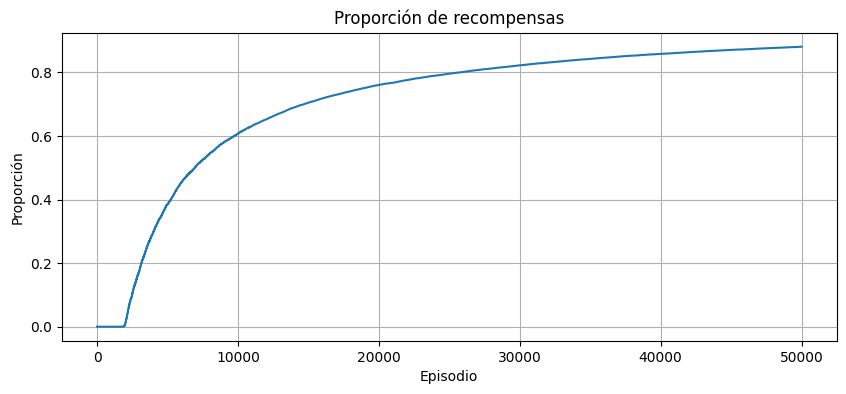

In [69]:
plot(list_stats_4)

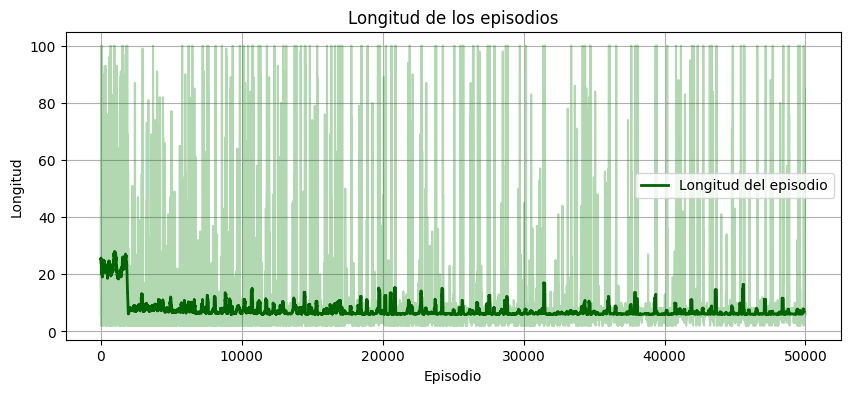

In [70]:
plot_len_tendency(list_len_4)

## Evaluación 4x4

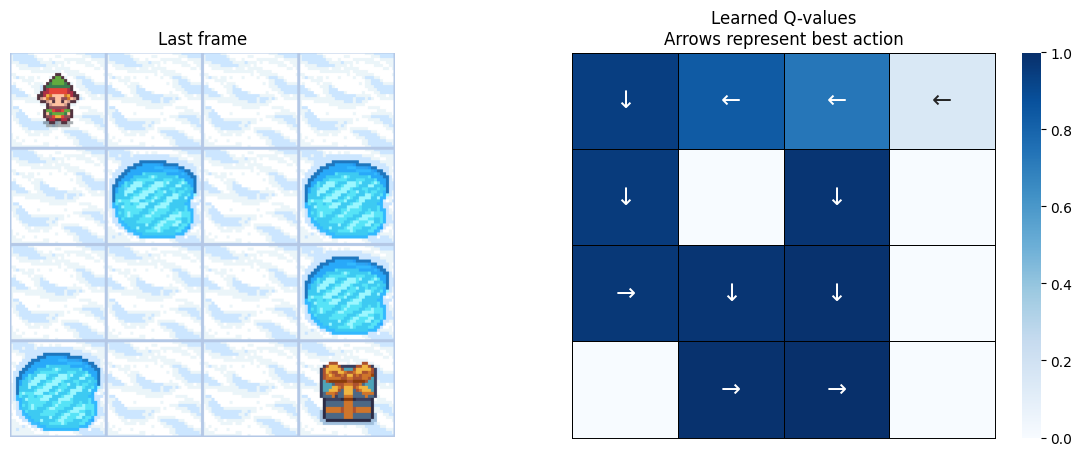

In [71]:
env4.reset(seed=SEED)
plot_q_values_map(agent_4.get_Q(), env4, 4)

In [72]:
# Ejecutar un episodio utilizando la política greedy y capturar los fotogramas.
total_reward, len_episode, frames = run_episode_greedy(agent_4)

# Crear el GIF a partir de los fotogramas capturados.
gif_path_4 = frames_to_gif(frames, "FL_4x4_SARSA.gif")
print("GIF guardado en:", gif_path_4)

GIF guardado en: FL_4x4_SARSA.gif


In [73]:
display_gif(gif_path_4)

### Caso 8x8

In [74]:
env8 = make_env_fl(name_fl, "8x8", "rgb_array", max_episode_steps=100)

In [85]:
agent_8 = AgentSARSA(env8, epsilon=1.0, alpha=0.1, gamma=0.99, decay=True)

In [86]:
n_episodes = 50000
list_stats_8, list_len_8 = train(agent_8, n_episodes)

 11%|█         | 5292/50000 [00:02<00:20, 2221.65it/s]

Recompensa promedio: 0.4788, epsilon: 0.19996000799840033


 20%|██        | 10192/50000 [00:05<00:17, 2249.92it/s]

Recompensa promedio: 0.6662, epsilon: 0.0999900009999


 31%|███       | 15270/50000 [00:08<00:19, 1793.89it/s]

Recompensa promedio: 0.7446666666666667, epsilon: 0.06666222251849876


 41%|████      | 20586/50000 [00:10<00:10, 2723.89it/s]

Recompensa promedio: 0.791, epsilon: 0.04999750012499375


 50%|█████     | 25222/50000 [00:12<00:10, 2288.98it/s]

Recompensa promedio: 0.82292, epsilon: 0.03999840006399744


 61%|██████    | 30473/50000 [00:14<00:06, 2880.96it/s]

Recompensa promedio: 0.8415333333333334, epsilon: 0.033332222259258026


 71%|███████   | 35452/50000 [00:15<00:05, 2754.07it/s]

Recompensa promedio: 0.8588857142857143, epsilon: 0.02857061226822091


 81%|████████  | 40499/50000 [00:17<00:03, 2749.03it/s]

Recompensa promedio: 0.8715, epsilon: 0.02499937501562461


 90%|█████████ | 45206/50000 [00:20<00:03, 1523.83it/s]

Recompensa promedio: 0.8818, epsilon: 0.02222172840603542


100%|██████████| 50000/50000 [00:21<00:00, 2275.96it/s]


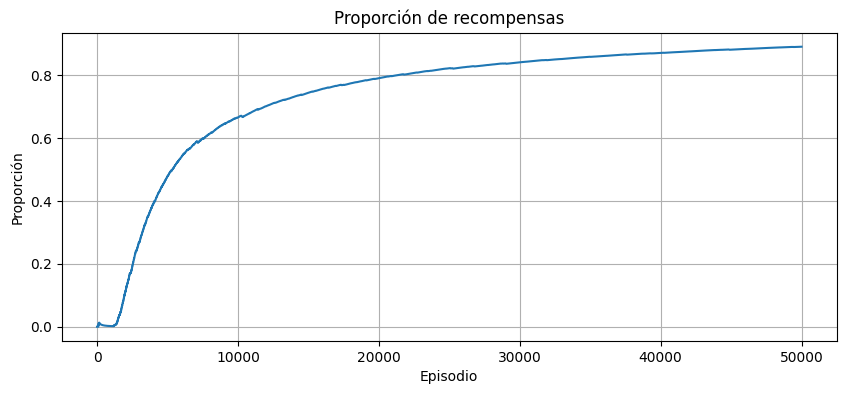

In [87]:
#plot_comparative(dict_stats_8)
plot(list_stats_8)

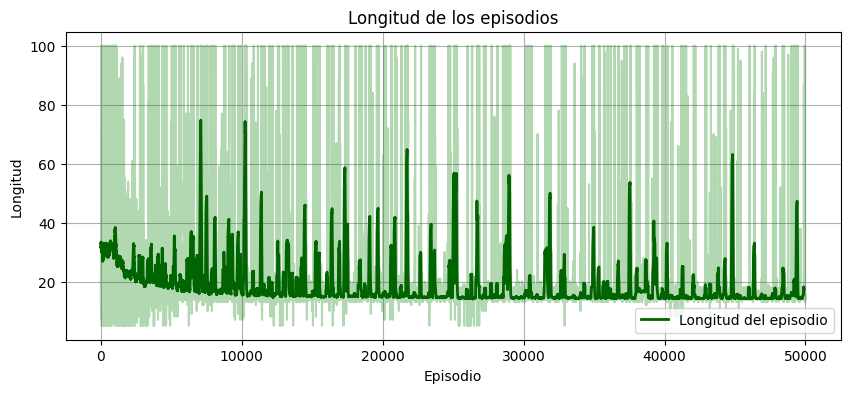

In [88]:
#plot_comparative(dict_len_8)
plot_len_tendency(list_len_8)

## Evaluación 8x8

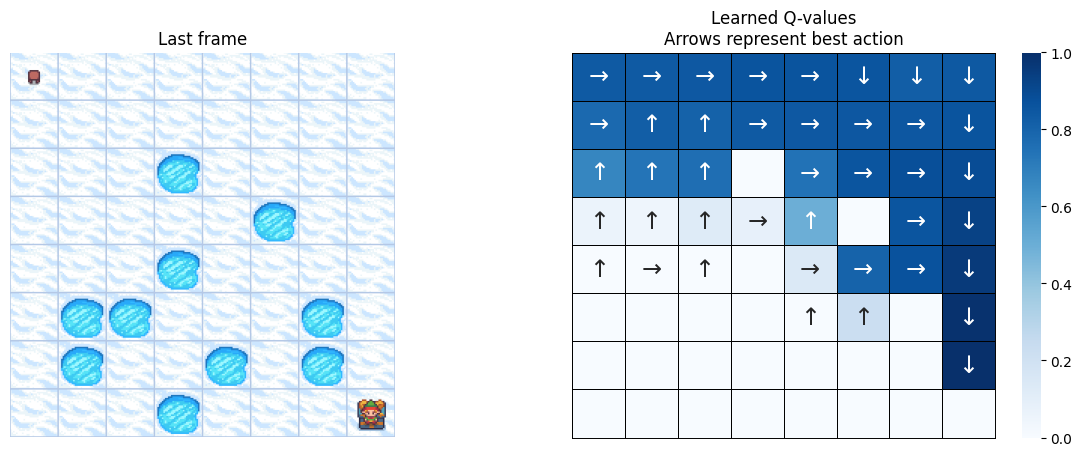

In [89]:
plot_q_values_map(agent_8.get_Q(), env8, 8)

In [90]:
# Ejecutar un episodio utilizando la política greedy y capturar los fotogramas.
total_reward, len_episode, frames = run_episode_greedy(agent_8)

# Crear el GIF a partir de los fotogramas capturados.
gif_path_8 = frames_to_gif(frames, "FL_8x8_SARSA.gif")
print("GIF guardado en:", gif_path_8)

GIF guardado en: FL_8x8_SARSA.gif


In [91]:
display_gif(gif_path_8)

Almacenamos las listas con los resultados para su posterior estudio.

In [92]:
import pickle

with open("stats_4_SARSA.pkl", "wb") as f:
    pickle.dump(list_stats_4, f)

with open("len_4_SARSA.pkl", "wb") as f:
    pickle.dump(list_len_4, f)

with open("stats_8_SARSA.pkl", "wb") as f:
    pickle.dump(list_stats_8, f)

with open("len_8_SARSA.pkl", "wb") as f:
    pickle.dump(list_len_8, f)